In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.nn.utils import spectral_norm
import librosa
import os
import json
import soundfile as sf
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
import copy
from scipy import signal
import librosa.display
from IPython.display import Audio

In [2]:
SAMPLE_RATE = 16000
FRAME_SHIFT = 0.0125
FRAME_LENGTH = 0.05
TOP_DB = 15
PREEMHPASIS = 0.97
N_FFT = 2048
HOP_LENGTH = int(SAMPLE_RATE*FRAME_SHIFT)
WIN_LENTGH = int(SAMPLE_RATE*FRAME_LENGTH)
N_MELS = 512
REF_DB = 20
MAX_DB = 100
N_GRIFFIN_LIM_ITER = 100
FRAME_SIZE = 1

def get_spectrograms(fpath):
    """
    Returns mel spect from wav file.
    """
    y, sr = librosa.load(fpath, sr=SAMPLE_RATE)
    y, _ = librosa.effects.trim(y, top_db=TOP_DB)
    y = np.append(y[0], y[1:] - PREEMHPASIS * y[:-1])
    # stft
    linear = librosa.stft(y=y,
                          n_fft=N_FFT,
                          hop_length=HOP_LENGTH,
                          win_length=WIN_LENTGH)

    mag = np.abs(linear)
    # mel spectrogram
    mel_basis = librosa.filters.mel(sr=SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS)
    mel = np.dot(mel_basis, mag)
    # to decibel
    mel = 20 * np.log10(np.maximum(1e-5, mel))
    # normalize
    mel = np.clip((mel - REF_DB + MAX_DB) / MAX_DB, 1e-8, 1)
    # Transpose
    mel = mel.T.astype(np.float32)

    return mel, y

def infinite_iter(loader):
    it = iter(loader)
    while True:
        try:
            ret = next(it)
            yield ret
        except StopIteration:
            it = iter(loader)

def save_model(model, optimizer, iteration):
        torch.save(model.state_dict(), f'model_save_iter_{iteration}.ckpt')
        torch.save(optimizer.state_dict(), f'opt_save_iter_{iteration}.opt')
        print("Saving model ===>>>")

def invert_spectrogram(spectrogram):
    '''
    spectrogram: [f, t]
    '''
    return librosa.istft(spectrogram, hop_length = HOP_LENGTH, win_length=WIN_LENTGH, window="hann")

def griffin_lim(spectrogram):
    X_best = copy.deepcopy(spectrogram)
    for i in range(N_GRIFFIN_LIM_ITER):
        X_t = invert_spectrogram(X_best)
        est = librosa.stft(X_t, n_fft = N_FFT, hop_length = HOP_LENGTH, win_length = WIN_LENTGH)
        phase = est / np.maximum(1e-8, np.abs(est))
        X_best = spectrogram * phase
    X_t = invert_spectrogram(X_best)
    y = np.real(X_t)
    return y

def _mel_to_linear_matrix(sr, n_fft, n_mels):
    m = librosa.filters.mel(sr = sr, n_fft = n_fft,n_mels = n_mels)
    m_t = np.transpose(m)
    p = np.matmul(m, m_t)
    d = [1.0 / x if np.abs(x) > 1.0e-8 else x for x in np.sum(p, axis=0)]
    return np.matmul(m_t, np.diag(d))

def melspectrogram2wav(mel):
    mel = mel.T
    # de-noramlize
    mel = (np.clip(mel, 0, 1) * MAX_DB) - MAX_DB + REF_DB

    # to amplitude
    mel = np.power(10.0, mel * 0.05)
    m = _mel_to_linear_matrix(SAMPLE_RATE, N_FFT, N_MELS)
    mag = np.dot(m, mel)
    # wav reconstruction
    wav = griffin_lim(mag)
    # de-preemphasis
    wav = signal.lfilter([1], [1, -PREEMHPASIS], wav)
    # trim
    wav, _ = librosa.effects.trim(wav)
    return wav.astype(np.float32)

In [3]:
CONFIG = {
    "ContentEncoder": {
        "c_in": 512,
        "c_h": 128,
        "c_out": 128,
        "kernel_size": 5,
        "bank_size": 8,
        "bank_scale": 1,
        "c_bank": 128,
        "n_conv_blocks": 6,
        "subsample": [
            1,
            2,
            1,
            2,
            1,
            2
        ],
        "act": "relu",
        "dropout_rate": 0
    },
    "Decoder": {
        "c_in": 128,
        "c_cond": 128,
        "c_h": 128,
        "c_out": 512,
        "kernel_size": 5,
        "n_conv_blocks": 6,
        "upsample": [
            2,
            1,
            2,
            1,
            2,
            1
        ],
        "act": "relu",
        "sn": False,
        "dropout_rate": 0
    },
    "optimizer": {
        "lr": 0.0005,
        "beta1": 0.9,
        "beta2": 0.98,
        "amsgrad": True,
        "weight_decay": 0.0001,
        "grad_norm": 5
    },
    "lambda": {
        "lambda_rec": 10,
        "lambda_kl": 1
    },
    "data_loader": {
        "batch_size": 8
    },
    "annealing_iters": 25000,
    "dataset_path": "../data/data",
    "n_iterations": 120000,
    "save_frequency": 40000
}

In [4]:
def pad_layer(inp, layer, pad_type='reflect'):
    kernel_size = layer.kernel_size[0]
    if kernel_size % 2 == 0:
        pad = (kernel_size//2, kernel_size//2 - 1)
    else:
        pad = (kernel_size//2, kernel_size//2)
    # padding
    inp = F.pad(inp, 
            pad=pad,
            mode=pad_type)
    out = layer(inp)
    return out

def pad_layer_2d(inp, layer, pad_type='reflect'):
    kernel_size = layer.kernel_size
    if kernel_size[0] % 2 == 0:
        pad_lr = [kernel_size[0]//2, kernel_size[0]//2 - 1]
    else:
        pad_lr = [kernel_size[0]//2, kernel_size[0]//2]
    if kernel_size[1] % 2 == 0:
        pad_ud = [kernel_size[1]//2, kernel_size[1]//2 - 1]
    else:
        pad_ud = [kernel_size[1]//2, kernel_size[1]//2]
    pad = tuple(pad_lr + pad_ud)
    # padding
    inp = F.pad(inp, 
            pad=pad,
            mode=pad_type)
    out = layer(inp)
    return out

def pixel_shuffle_1d(inp, scale_factor=2):
    batch_size, channels, in_width = inp.size()
    channels //= scale_factor
    out_width = in_width * scale_factor
    inp_view = inp.contiguous().view(batch_size, channels, scale_factor, in_width)
    shuffle_out = inp_view.permute(0, 1, 3, 2).contiguous()
    shuffle_out = shuffle_out.view(batch_size, channels, out_width)
    return shuffle_out

def upsample(x, scale_factor=2):
    x_up = F.interpolate(x, scale_factor=scale_factor, mode='nearest')
    return x_up

def append_cond(x, cond):
    # x = [batch_size, x_channels, length]
    # cond = [batch_size, x_channels * 2]
    p = cond.size(1) // 2
    mean, std = cond[:, :p], cond[:, p:]
    out = x * std.unsqueeze(dim=2) + mean.unsqueeze(dim=2)
    return out

def conv_bank(x, module_list, act, pad_type='reflect'):
    outs = []
    for layer in module_list:
        out = act(pad_layer(x, layer, pad_type))
        outs.append(out)
    out = torch.cat(outs + [x], dim=1)
    return out

def get_act(act):
    if act == 'relu':
        return nn.ReLU()
    elif act == 'lrelu':
        return nn.LeakyReLU()
    else:
        return nn.ReLU()

class Inception(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Inception, self).__init__()
        self.block1 = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size = (1,1)), nn.ReLU())
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = (1, 1)),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = (1,3), padding = (0,1), padding_mode = "reflect"),
            nn.ReLU()
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = (1, 1)),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = (1, 5), padding = (0, 2), padding_mode = "reflect"),
            nn.ReLU()
        )
        self.block4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3,1), stride=(1,1)),
            nn.Conv2d(in_channels, out_channels, kernel_size = (1, 1), padding=(1,0), padding_mode = "reflect"),
            nn.ReLU()
        )

    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x)
        x3 = self.block3(x)
        x4 = self.block4(x)
        return torch.cat([x1,x2, x3,x4], axis = 1)

class ReduceBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        mid_channel_size = (in_channels + out_channels) // 2
        self.conv1 = nn.Conv2d(
            in_channels = in_channels,
            out_channels = mid_channel_size,
            kernel_size = (3,3)
        )
        self.conv2 = nn.Conv2d(
            in_channels = mid_channel_size,
            out_channels = 1,# returns only 1 channel data
            kernel_size = (3,3)
        )
        self.out_conv = nn.Conv1d(
            in_channels = 508,
            out_channels = out_channels,
            kernel_size = 5
        )
        self.pool_layer = nn.AdaptiveAvgPool1d(1)
        # regarding to the paper, some linear layers can be added
    
    def forward(self, x):
        result = F.relu(self.conv1(x))
        result = F.relu(self.conv2(result)).squeeze(1)
        result = F.relu(self.out_conv(result))
        return self.pool_layer(result).squeeze(2)

class LinearBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_linears = 3):
        super().__init__()
        self.n_linears = n_linears - 1
        self.input_linear = nn.Linear(
            in_features = in_channels,
            out_features = out_channels
        )
        self.linears = nn.ModuleList([nn.Linear(out_channels, out_channels) for _ in range(self.n_linears)])
    
    def forward(self, x):
        output = F.relu(self.input_linear(x))
        for module in self.linears:
            output = F.relu(module(output))
        return output

class SpeakerEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.inception1 = Inception(1, 8)
        # reduce blocks
        self.reduce1 = ReduceBlock(32, 128)
        # linear block
        self.out_block = LinearBlock(128, 128)
    
    def forward(self, x):
        out = self.inception1(x)
        out = self.reduce1(out)
        out = self.out_block(out)
        return out

class ContentEncoder(nn.Module):
    def __init__(self, c_in, c_h, c_out, kernel_size,
            bank_size, bank_scale, c_bank, 
            n_conv_blocks, subsample, 
            act, dropout_rate):
        super(ContentEncoder, self).__init__()
        self.n_conv_blocks = n_conv_blocks
        self.subsample = subsample
        self.act = get_act(act)
        self.conv_bank = nn.ModuleList(
                [nn.Conv1d(c_in, c_bank, kernel_size=k) for k in range(bank_scale, bank_size + 1, bank_scale)])
        in_channels = c_bank * (bank_size // bank_scale) + c_in
        self.in_conv_layer = nn.Conv1d(in_channels, c_h, kernel_size=1)
        self.first_conv_layers = nn.ModuleList([nn.Conv1d(c_h, c_h, kernel_size=kernel_size) for _ \
                in range(n_conv_blocks)])
        self.second_conv_layers = nn.ModuleList([nn.Conv1d(c_h, c_h, kernel_size=kernel_size, stride=sub) 
            for sub, _ in zip(subsample, range(n_conv_blocks))])
        self.norm_layer = nn.InstanceNorm1d(c_h, affine=False)
        self.mean_layer = nn.Conv1d(c_h, c_out, kernel_size=1)
        self.std_layer = nn.Conv1d(c_h, c_out, kernel_size=1)
        self.dropout_layer = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        out = conv_bank(x, self.conv_bank, act=self.act)
        # dimension reduction layer
        out = pad_layer(out, self.in_conv_layer)
        out = self.norm_layer(out)
        out = self.act(out)
        out = self.dropout_layer(out)
        # convolution blocks
        for l in range(self.n_conv_blocks):
            y = pad_layer(out, self.first_conv_layers[l])
            y = self.norm_layer(y)
            y = self.act(y)
            y = self.dropout_layer(y)
            y = pad_layer(y, self.second_conv_layers[l])
            y = self.norm_layer(y)
            y = self.act(y)
            y = self.dropout_layer(y)
            if self.subsample[l] > 1:
                out = F.avg_pool1d(out, kernel_size=self.subsample[l], ceil_mode=True)
            out = y + out
        mu = pad_layer(out, self.mean_layer)
        log_sigma = pad_layer(out, self.std_layer)
        return mu, log_sigma

class Decoder(nn.Module):
    def __init__(self, 
            c_in, c_cond, c_h, c_out, 
            kernel_size,
            n_conv_blocks, upsample, act, sn, dropout_rate):
        super(Decoder, self).__init__()
        self.n_conv_blocks = n_conv_blocks
        self.upsample = upsample
        self.act = get_act(act)
        f = spectral_norm if sn else lambda x: x
        self.in_conv_layer = f(nn.Conv1d(c_in, c_h, kernel_size=1))
        self.first_conv_layers = nn.ModuleList([f(nn.Conv1d(c_h, c_h, kernel_size=kernel_size)) for _ \
                in range(n_conv_blocks)])
        self.second_conv_layers = nn.ModuleList(\
                [f(nn.Conv1d(c_h, c_h * up, kernel_size=kernel_size)) \
                for _, up in zip(range(n_conv_blocks), self.upsample)])
        self.norm_layer = nn.InstanceNorm1d(c_h, affine=False)
        self.conv_affine_layers = nn.ModuleList(
                [f(nn.Linear(c_cond, c_h * 2)) for _ in range(n_conv_blocks*2)])
        self.out_conv_layer = f(nn.Conv1d(c_h, c_out, kernel_size=1))
        self.dropout_layer = nn.Dropout(p=dropout_rate)

    def forward(self, z, cond):
        out = pad_layer(z, self.in_conv_layer)
        out = self.norm_layer(out)
        out = self.act(out)
        out = self.dropout_layer(out)
        # convolution blocks
        for l in range(self.n_conv_blocks):
            y = pad_layer(out, self.first_conv_layers[l])
            y = self.norm_layer(y)
            y = append_cond(y, self.conv_affine_layers[l*2](cond))
            y = self.act(y)
            y = self.dropout_layer(y)
            y = pad_layer(y, self.second_conv_layers[l])
            if self.upsample[l] > 1:
                y = pixel_shuffle_1d(y, scale_factor=self.upsample[l])
            y = self.norm_layer(y)
            y = append_cond(y, self.conv_affine_layers[l*2+1](cond))
            y = self.act(y)
            y = self.dropout_layer(y)
            if self.upsample[l] > 1:
                out = y + upsample(out, scale_factor=self.upsample[l]) 
            else:
                out = y + out
        out = pad_layer(out, self.out_conv_layer)
        return out

class AE(nn.Module):
    def __init__(self, config):
        super(AE, self).__init__()
        self.speaker_encoder = SpeakerEncoder()
        self.content_encoder = ContentEncoder(**config['ContentEncoder'])
        self.decoder = Decoder(**config['Decoder'])

    def forward(self, x):
        x_embed = x if len(x.shape) == 4 else x.unsqueeze(1)
        emb = self.speaker_encoder(x_embed)
        mu, log_sigma = self.content_encoder(x)
        eps = log_sigma.new(*log_sigma.size()).normal_(0, 1)
        dec = self.decoder(mu + torch.exp(log_sigma / 2) * eps, emb)
        return mu, log_sigma, emb, dec

    def inference(self, x, x_cond):
        x_cond = x_cond if len(x_cond.shape) == 4 else x_cond.unsqueeze(1)
        emb = self.speaker_encoder(x_cond)
        mu, _ = self.content_encoder(x)
        dec = self.decoder(mu, emb)
        return dec

    def get_speaker_embeddings(self, x):
        x = x if len(x.shape) == 4 else x.unsqueeze(1)
        emb = self.speaker_encoder(x)
        return emb

In [5]:
MODEL_PATH = os.path.join("..", "models", "vae-inception-3", "model_save_iter_79999.ckpt")

source_speaker = "speaker2"
target_speaker = "speaker3"
source_sample = "arctic_a0010.wav"
target_sample = "arctic_a0011.wav"

DATA_PATH = os.path.join("..", "spk_data")
SOURCE_SPEECH = os.path.join(DATA_PATH, source_speaker, source_sample)
TARGET_SPEECH = os.path.join(DATA_PATH, target_speaker, target_sample)

CONVERSION_PATH = os.path.join("models", "vae-inception", "conversions")
SRC_TARGET_CONVERSION = os.path.join(CONVERSION_PATH, f"{source_speaker}_{target_speaker}_{source_sample}")
TARGET_SRC_CONVERSION = os.path.join(CONVERSION_PATH, f"{target_speaker}_{source_speaker}_{target_sample}")

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = AE(CONFIG).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [7]:
# voice preparation
source_mel, _ = get_spectrograms(SOURCE_SPEECH)
target_mel, _ = get_spectrograms(TARGET_SPEECH)
#
mean = np.mean(np.vstack([source_mel, target_mel]))
std = np.std(np.vstack([source_mel, target_mel]))
# normalize
source_mel = (source_mel - mean) / std
target_mel = (target_mel - mean) / std

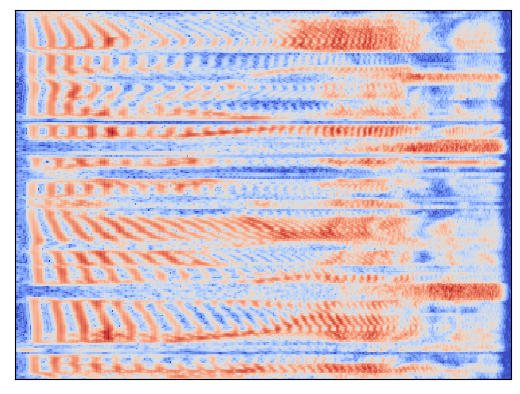

In [8]:
librosa.display.specshow(source_mel)

In [9]:
source_mel, target_mel = torch.from_numpy(source_mel).to(DEVICE), torch.from_numpy(target_mel).to(DEVICE)

with torch.no_grad():
    source_target = model.inference(source_mel.T.unsqueeze(0), target_mel.T.unsqueeze(0))
    target_source = model.inference(target_mel.T.unsqueeze(0), source_mel.T.unsqueeze(0))

In [10]:
source_target = (source_target.squeeze(0).cpu().numpy().T * std) + mean
target_source = (target_source.squeeze(0).cpu().numpy().T * std) + mean

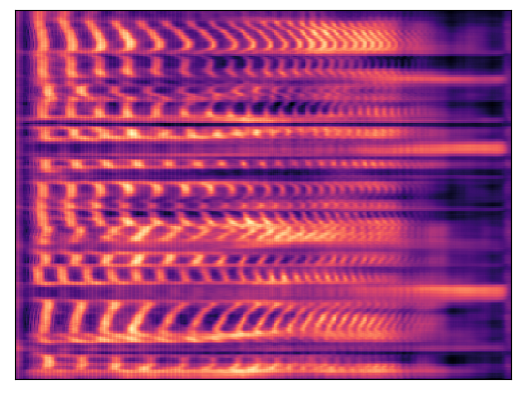

In [11]:
librosa.display.specshow(source_target)

In [12]:
source_target = melspectrogram2wav(source_target)
Audio(source_target, rate = SAMPLE_RATE)

In [13]:
target_source = melspectrogram2wav(target_source)
Audio(target_source, rate = SAMPLE_RATE)

In [14]:
source_speaker = "speaker2"
target_speaker = "speaker7"
source_sample = "arctic_a0011.wav"
target_sample = "arctic_a0012.wav"

DATA_PATH = os.path.join("..", "spk_data")
SOURCE_SPEECH = os.path.join(DATA_PATH, source_speaker, source_sample)
TARGET_SPEECH = os.path.join(DATA_PATH, target_speaker, target_sample)

CONVERSION_PATH = os.path.join("..", "models", "vae-inception", "conversions")
SRC_TARGET_CONVERSION = os.path.join(CONVERSION_PATH, f"{source_speaker}_{target_speaker}_{source_sample}")
TARGET_SRC_CONVERSION = os.path.join(CONVERSION_PATH, f"{target_speaker}_{source_speaker}_{target_sample}")

# voice preparation
source_mel, source_speech = get_spectrograms(SOURCE_SPEECH)
target_mel, target_speech = get_spectrograms(TARGET_SPEECH)
#
mean = np.mean(np.vstack([source_mel, target_mel]))
std = np.std(np.vstack([source_mel, target_mel]))
# normalize
source_mel = (source_mel - mean) / std
target_mel = (target_mel - mean) / std

source_mel, target_mel = torch.from_numpy(source_mel).to(DEVICE), torch.from_numpy(target_mel).to(DEVICE)

with torch.no_grad():
    source_target = model.inference(source_mel.T.unsqueeze(0), target_mel.T.unsqueeze(0))
    target_source = model.inference(target_mel.T.unsqueeze(0), source_mel.T.unsqueeze(0))

source_target = (source_target.squeeze(0).cpu().numpy().T * std) + mean
target_source = (target_source.squeeze(0).cpu().numpy().T * std) + mean

source_target = melspectrogram2wav(source_target)
target_source = melspectrogram2wav(target_source)
Audio(np.hstack([source_target, np.zeros(20),  target_speech]), rate = SAMPLE_RATE)

In [15]:
Audio(np.hstack([target_source, np.zeros(20), source_speech]), rate = SAMPLE_RATE)

In [25]:
source_speaker = "speaker4"
target_speaker = "speaker7"
source_sample = "arctic_a0012.wav"
target_sample = "arctic_a0012.wav"

DATA_PATH = os.path.join("..", "spk_data")
SOURCE_SPEECH = os.path.join(DATA_PATH, source_speaker, source_sample)
TARGET_SPEECH = os.path.join(DATA_PATH, target_speaker, target_sample)

CONVERSION_PATH = os.path.join("..", "models", "vae-inception", "conversions")
SRC_TARGET_CONVERSION = os.path.join(CONVERSION_PATH, f"{source_speaker}_{target_speaker}_{source_sample}")
TARGET_SRC_CONVERSION = os.path.join(CONVERSION_PATH, f"{target_speaker}_{source_speaker}_{target_sample}")

# voice preparation
source_mel, source_speech = get_spectrograms(SOURCE_SPEECH)
target_mel, target_speech = get_spectrograms(TARGET_SPEECH)
#
mean = np.mean(np.vstack([source_mel, target_mel]))
std = np.std(np.vstack([source_mel, target_mel]))
# normalize
source_mel = (source_mel - mean) / std
target_mel = (target_mel - mean) / std

source_mel, target_mel = torch.from_numpy(source_mel).to(DEVICE), torch.from_numpy(target_mel).to(DEVICE)

with torch.no_grad():
    source_target = model.inference(source_mel.T.unsqueeze(0), target_mel.T.unsqueeze(0))
    target_source = model.inference(target_mel.T.unsqueeze(0), source_mel.T.unsqueeze(0))

source_target = (source_target.squeeze(0).cpu().numpy().T * std) + mean
target_source = (target_source.squeeze(0).cpu().numpy().T * std) + mean

source_target = melspectrogram2wav(source_target)
target_source = melspectrogram2wav(target_source)
Audio(np.hstack([source_target, np.zeros(20),  target_speech]), rate = SAMPLE_RATE)

In [26]:
Audio(np.hstack([target_source, np.zeros(20), source_speech]), rate = SAMPLE_RATE)

In [30]:
Audio(target_speech, rate = SAMPLE_RATE)